In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from imgaug import augmenters as iaa
import inspect
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
from shutil import copy
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)

In [3]:
img_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/soft computing/Project/ORIGA/glaucoma.csv')
img_data

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [4]:
batch_size = 16
epochs = 100

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [6]:
input = Input(shape=input_shape)

In [7]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [8]:
model.summary()
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      416       
_________________________________________________________________
activation (Activation)      (None, 255, 255, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      4128      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
# Initiate the train and test generators with data Augumentation
sometimes = lambda aug: iaa.Sometimes(0.6, aug)
seq = iaa.Sequential([
                      iaa.GaussianBlur(sigma=(0 , 1.0)),
                      iaa.Sharpen(alpha=1, lightness=0),
                      iaa.CoarseDropout(p=0.1, size_percent=0.15),
                              sometimes(iaa.Affine(
                                                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                    rotate=(-30, 30),
                                                    shear=(-16, 16)))
                    ])

In [10]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/soft computing/Project/ORIGA/train',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'binary',
     subset = 'training',
     shuffle=True)



test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/soft computing/Project/ORIGA/test',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     shuffle = False,
     class_mode = 'binary')

Found 455 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [11]:
history = model.fit(
    training_set,
    epochs=epochs,
    validation_data=test_set,
    verbose = 1
)

Epoch 1/100
29/29 [==============================] - 147s 5s/step - loss: 0.6836 - accuracy: 0.5714 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 2/100
29/29 [==============================] - 33s 1s/step - loss: 0.6897 - accuracy: 0.5363 - val_loss: 0.6880 - val_accuracy: 0.5625
Epoch 3/100
29/29 [==============================] - 33s 1s/step - loss: 0.6824 - accuracy: 0.5670 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 32s 1s/step - loss: 0.6752 - accuracy: 0.5670 - val_loss: 0.6876 - val_accuracy: 0.5156
Epoch 5/100
29/29 [==============================] - 32s 1s/step - loss: 0.6726 - accuracy: 0.5648 - val_loss: 0.6762 - val_accuracy: 0.5625
Epoch 6/100
29/29 [==============================] - 33s 1s/step - loss: 0.6596 - accuracy: 0.6066 - val_loss: 0.6646 - val_accuracy: 0.5781
Epoch 7/100
29/29 [==============================] - 33s 1s/step - loss: 0.6466 - accuracy: 0.6132 - val_loss: 0.6577 - val_accuracy: 0.5312
Epoch 8/100


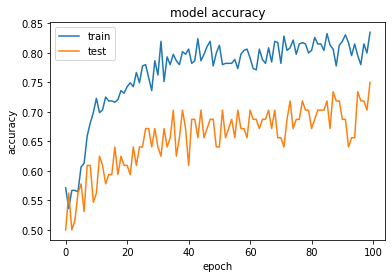

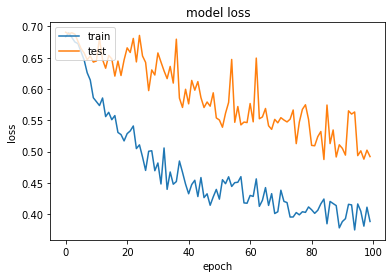

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
print('Classification Report')
print(metrics.classification_report(test_set.classes, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        32
           1       0.00      0.00      0.00        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
cm = metrics.confusion_matrix(test_set.classes, y_pred)
print(cm)

[[32  0]
 [32  0]]


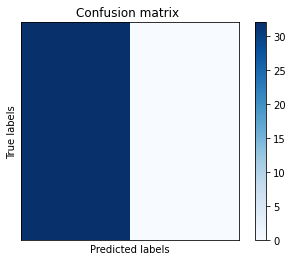

In [31]:
cm = metrics.confusion_matrix(test_set.classes, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()